In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import pickle
from skimage.feature import hog
import skimage
import random
import os
from scipy import ndimage
import imutils
import math
import sys
# sys.path.insert(1, './Code/')
# from handdetector import handDetector
%matplotlib inline

In [2]:
def getAngle(a, b, c):
    ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang

In [3]:
def find_parent(parent, i):
    if(parent[i]==  i):
        return i
    return find_parent(parent, parent[i])

In [4]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
 
    return cv2.LUT(image, table)

In [5]:
def shrink_array(cntsarray):
    finalcnts= []
    sumarray= (np.sum(np.sum(np.sum(cntsarray, axis= 1), axis= 1), axis= 1))
    print (sumarray)
    parent= np.arange(len(sumarray))
    print (parent)
    for i in range(len(sumarray)):
        for j in range(len(sumarray)):
            if(i!= j and abs(sumarray[i]-sumarray[j])<= 10):
                a= find_parent(parent, i)
                b= find_parent(parent, j)
                parent[b]= a
    for i in range(len(parent)):
        if(parent[i]== i):
            finalcnts.append(cntsarray[i])
    return finalcnts

In [6]:
def flattener(image, pts, w, h):
    temp_rect = np.zeros((4,2), dtype = "float32")
    
    s = np.sum(pts, axis = 2)

    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]

    diff = np.diff(pts, axis = -1)
    tr = pts[np.argmin(diff)]
    bl = pts[np.argmax(diff)]

    # Need to create an array listing points in order of
    # [top left, top right, bottom right, bottom left]
    # before doing the perspective transform

    if w <= 0.8*h: # If card is vertically oriented
        temp_rect[0] = tl
        temp_rect[1] = tr
        temp_rect[2] = br
        temp_rect[3] = bl

    if w >= 1.2*h: # If card is horizontally oriented
        temp_rect[0] = bl
        temp_rect[1] = tl
        temp_rect[2] = tr
        temp_rect[3] = br

    # If the card is 'diamond' oriented, a different algorithm
    # has to be used to identify which point is top left, top right
    # bottom left, and bottom right.
    
    if w > 0.8*h and w < 1.2*h: #If card is diamond oriented
        # If furthest left point is higher than furthest right point,
        # card is tilted to the left.
        if pts[1][0][1] <= pts[3][0][1]:
            # If card is titled to the left, approxPolyDP returns points
            # in this order: top right, top left, bottom left, bottom right
            temp_rect[0] = pts[1][0] # Top left
            temp_rect[1] = pts[0][0] # Top right
            temp_rect[2] = pts[3][0] # Bottom right
            temp_rect[3] = pts[2][0] # Bottom left

        # If furthest left point is lower than furthest right point,
        # card is tilted to the right
        if pts[1][0][1] > pts[3][0][1]:
            # If card is titled to the right, approxPolyDP returns points
            # in this order: top left, bottom left, bottom right, top right
            temp_rect[0] = pts[0][0] # Top left
            temp_rect[1] = pts[3][0] # Top right
            temp_rect[2] = pts[2][0] # Bottom right
            temp_rect[3] = pts[1][0] # Bottom left
            
        
    maxWidth = 200
    maxHeight = 300
    dst = np.array([[0,0],[maxWidth-1,0],[maxWidth-1,maxHeight-1],[0, maxHeight-1]], np.float32)
    M = cv2.getPerspectiveTransform(temp_rect,dst)
    warp = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warp


In [7]:
def get_rank(imarray, cnt):
    card= cnt
    x,y,w,h= cv2.boundingRect(card)
    warp1= flattener(imarray, card, w, h)
#     print (warp1.shape)
    cv2.imwrite('./pers.png', warp1)
    plt.imshow(warp1)
    plt.show()
    warp1= warp1[6:45, 5:34]
    return warp1

In [8]:
def get_suit(imarray, cnt):
    card= cnt
    x,y,w,h= cv2.boundingRect(card)
    warp1= flattener(imarray, card, w, h)
#     print (warp1.shape)
    plt.imshow(warp1)
    plt.show()
    warp1= warp1[44:77, 5:34]
    return warp1

In [9]:
def card_detect(loc):
    imarray= np.array(cv2.imread(loc, 0))
    print (imarray.shape)
    imblur1= cv2.GaussianBlur(imarray, (5,5), 0)
    imgamma1= adjust_gamma(imblur1, 0.5)
    cv2.imwrite('./blur.png', imblur1)
    imblur2= cv2.GaussianBlur(imarray, (7,7), 0)
    imgamma2= adjust_gamma(imblur2, 0.5)
    plt.imshow(imblur1, cmap= 'gray')
    plt.title("After Gaussian Blur")
    plt.show()
    
    high_thresh, thresh_im = cv2.threshold(imblur1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    low_thresh = 0.30*high_thresh
    edgearray1= cv2.Canny(imblur1, low_thresh, high_thresh)
    cv2.imwrite('./edge.png', edgearray1)
    high_thresh, thresh_im = cv2.threshold(imblur2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    low_thresh = 0.20*high_thresh
    edgearray2= cv2.Canny(imblur2, low_thresh, high_thresh)
    plt.imshow(edgearray1, cmap= 'gray')
    plt.title("After Edge detection")
    plt.show()
    cnts1= cv2.findContours(edgearray1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts1= imutils.grab_contours(cnts1)
    cnts2= cv2.findContours(edgearray2.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts2= imutils.grab_contours(cnts2)
    cnts1.extend(cnts2)
    cnts= sorted(cnts1, key = cv2.contourArea, reverse = True)[:25]
    print (len(cnts))
    
    cntsarray= []
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.009*peri, True)
        if (len(approx)== 4):#card will be a rectangle always
            cntsarray.append(approx)
            
    imarraycolor= np.array(cv2.imread(loc))
    print (len(cntsarray))
    cv2.drawContours(imarraycolor, cntsarray, -1, (0, 255, 0), 3)
    plt.imshow(imarraycolor)
    plt.title("Contours detected")
    plt.show()
    cv2.imwrite('./op.png', imarraycolor)
    sumarray= (np.sum(np.sum(np.sum(cntsarray, axis= 1), axis= 1), axis= 1))
    a= shrink_array(cntsarray)
#     print (len(a))
    return a

In [14]:
cardDict= {'2':2, '3':3, '4':4, '5':5, '6':6, '7':7, '8':8, '9':9, '10':10, 'J':11, 'Q':12, 'K':13, 'A':14}
suitDict= {'Hearts':0, 'Diamond':1, 'Spades':2, 'Clubs':3}


# In[3]:


def check_royal_flush(cards, countmat):
    for i in range(len(countmat)):
        if(sum(countmat[i][-5:])== 5):
            return True
    return False


# In[4]:


def check_straight_flush(cards, countmat):
    for i in range(len(countmat)):
        for j in range(1, 7):
            if(sum(countmat[i][j:j+5])== 5):
                return True
        if(sum(countmat[i][0:4])== 4 and countmat[i][12]== 1):
            return True
    return False


# In[5]:


def check_four_kind(cards, countmat):
    for i in range(len(countmat[0])):
        if(sum(countmat[:, i])== 4):
            return True
    return False


# In[10]:


def check_full_house(cards, countmat):
    for i in range(len(countmat)):
        for j in range(len(countmat)):
            if(sum(countmat[i])== 3 and sum(countmat[j])== 2):
                return True
    return False


# In[8]:


def check_flush(cards, countmat):
    for i in range(len(countmat)):
        if(sum(countmat[i])>= 5):
            return True
    return False


# In[9]:


def check_straight(cards, countmat):
    cardcounts= np.zeros(13)
    for i in range(len(cards)):
        cardcounts[cardDict[cards[i][0]]-2]+= 1
    for i in range(0, 7):
        if(sum(cardcounts[i:i+5])>= 5 and max(cardcounts[i:i+5])-min(cardcounts[i:i+5])<= 1):
            return True
    if(sum(cardcounts[0:4])+cardcounts[12]>= 5 and max(max(cardcounts[0:4]), cardcounts[12])-min(min(cardcounts[0:4]), cardcounts[12])<= 1):
        return True
    return False


# In[2]:


def check_three_kind(cards, countmat):
    for i in range(len(countmat[0])):
        if(sum(countmat[:, i])== 3):
            return True
    return False


# In[1]:


def check_two_pairs(cards, countmat):
    for i in range(len(countmat[0])):
        for j in range(len(countmat[0])):
            if(i!= j and sum(countmat[:, i])== 2 and sum(countmat[:, j]== 2)):
                return True
    return False


# In[6]:


def check_pair(cards, countmat):
    for i in range(len(countmat[0])):
        if(sum(countmat[:, i])== 2):
            return True
    return False


# In[7]:


def check_high_card(cards, countmat):
    counts= np.sum(countmat, axis= 0)
    if(sum(counts[-4:])> 0):
        return True
    return False


# In[11]:


def handDetector(cards):#list of 7 tuples
    countmat= np.zeros((4, 13))
    for i in range(len(cards)):
        countmat[suitDict[cards[i][1]]][cardDict[cards[i][0]]-2]+= 1
    countmat= np.array(countmat)
    print (countmat)
    
    if(check_royal_flush(cards, countmat)):
        return "royal flush"
    if(check_straight_flush(cards, countmat)):
        return "straight flush"
    if(check_four_kind(cards, countmat)):
        return "four of kind"
    if(check_full_house(cards, countmat)):
        return "full house"
    if(check_flush(cards, countmat)):
        return "flush"
    if(check_straight(cards, countmat)):
        return "straight"
    if(check_three_kind(cards, countmat)):
        return "three of kind"
    if(check_two_pairs(cards, countmat)):
        return "two pairs"
    if(check_pair(cards, countmat)):
        return "pair"
    if(check_high_card(cards, countmat)):
        return "high card"
    return "bro just call it please!"

In [11]:
def rankplussuit_detect(imarray, cntsarray):
    f= open('./model.pkl', 'rb')
    clf= pickle.load(f)
    qclf=pickle.load(open('./model2.pkl', 'rb'))
    cards= []
    for cnt in cntsarray:
        obsrank= get_rank(imarray, cnt)
        obssuit= get_suit(imarray, cnt)
        rankPath= './templates1/ranks/'
        suitPath= './templates1/suits/'
        obsrankres= cv2.resize(obsrank, (20, 35))
        fd, hog_image = hog(obsrankres, orientations=9, pixels_per_cell=(8, 8), 
                        cells_per_block=(2, 2), visualize=True, multichannel=False)
        hog_image= np.reshape(hog_image, (1, hog_image.shape[0]*hog_image.shape[1]))[0]
        rp= str(clf.predict([hog_image])[0])
        print ("The rank of the card is: " + rp)
        
        obssuitres= cv2.resize(obssuit, (20, 35))
        fd, hog_image = hog(obssuitres, orientations=9, pixels_per_cell=(8, 8), 
                        cells_per_block=(2, 2), visualize=True, multichannel=False)
        hog_image= np.reshape(hog_image, (1, hog_image.shape[0]*hog_image.shape[1]))[0]
        sp= str(qclf.predict([hog_image])[0])
        print ("The suit of the card is: " + sp)
        cards.append([rp, sp])
    print (cards)
    return cards

In [12]:
def rankplussuit_detect2(imarray, cntsarray):
    cards= []
    for cnt in cntsarray:
        obsrank= get_rank(imarray, cnt)
        obssuit= get_suit(imarray, cnt)
        rankPath= './templates2/ranks/'
        suitPath= './templates2/suits/'
        ssesuits= []
        sseranks= []
        for fold in os.listdir(rankPath):
            summ= 0
            for img in os.listdir(os.path.join(rankPath, fold)):
                fullname= os.path.join(os.path.join(rankPath, fold), img)
                rank= np.array(cv2.imread(fullname, 0))
                minx= min(rank.shape[0], obsrank.shape[0])
                miny= min(rank.shape[1], obsrank.shape[1])
                obsrankres= cv2.resize(obsrank, (miny, minx))
                rankres= cv2.resize(rank, (miny, minx))
                fd, hog_image = hog(rankres, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, multichannel=False)
                fd2, hog_image2 = hog(obsrankres, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, multichannel=False)
                summ+= np.sum(np.abs(hog_image - hog_image2)**2)
            sseranks.append(summ)
        print (sseranks)
        rp= os.listdir(rankPath)[np.argmin(sseranks)]
        print ("The rank of the card is: " + os.listdir(rankPath)[np.argmin(sseranks)])
        
        for fold in os.listdir(suitPath):
            summ= 0
            flag= False
            for img in os.listdir(os.path.join(suitPath, fold)):
                fullname= os.path.join(os.path.join(suitPath, fold), img)
                suit= np.array(cv2.imread(fullname, 0))
                minx= min(suit.shape[0], obssuit.shape[0])
                miny= min(suit.shape[1], obssuit.shape[1])
                obssuitres= cv2.resize(obssuit, (miny, minx))
                suitres= cv2.resize(suit, (miny, minx))
                fd, hog_image = hog(suitres, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, multichannel=False)
                fd2, hog_image2 = hog(obssuitres, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, multichannel=False)
                summ+= np.sum(np.abs(hog_image - hog_image2)**2)
            ssesuits.append(summ)
        print (ssesuits)
        sp= os.listdir(suitPath)[np.argmin(ssesuits)]
        print ("The suit of the card is: " + os.listdir(suitPath)[np.argmin(ssesuits)])
        cards.append([rp, sp])
    print (cards)
    return cards

(1158, 869)


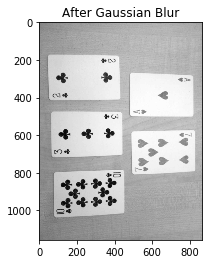

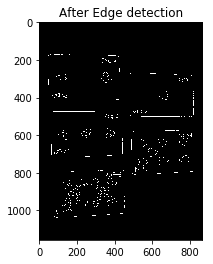

25
14


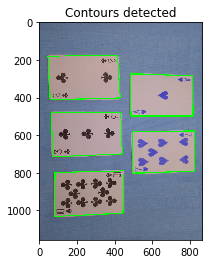

[2127 2124 3387 3387 4700 4699 4154 4154 4152 4152 5394 5392 5393 5392]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
5


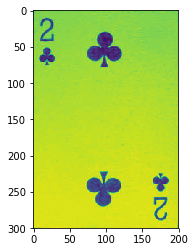

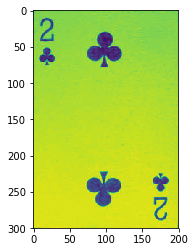

[9045.586797530777, 56516.55563777421, 41161.992532492855, 25158.511780016626, 43121.22051259088, 30890.797844868815, 56650.92727992401, 33891.006837867215, 63005.66063098863, 88136.83962686585, 33878.54733670739]
The rank of the card is: 2
[9757.137983934934, 3449.068480602592, 12318.624498178466, 9754.333706363728]
The suit of the card is: Clubs


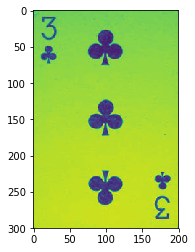

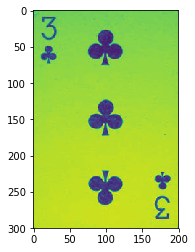

[37783.5380243289, 35586.68365993434, 30878.854055641335, 32560.55548976334, 46924.20326792494, 26289.355535879375, 43754.697498035224, 32530.701097268862, 65862.35180173919, 96615.7924377636, 12300.634553563632]
The rank of the card is: 3
[9756.12715626321, 4395.552937874707, 9687.832204325661, 7546.991591916464]
The suit of the card is: Clubs


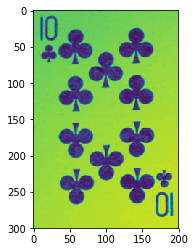

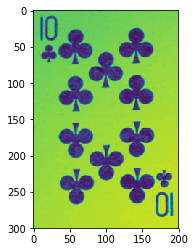

[42745.693840941836, 56031.97430252135, 42423.77775669552, 19240.13942795354, 10273.367298232606, 35059.84017443833, 36185.25179607012, 26714.839192993582, 64697.82128734411, 99576.27460591501, 33470.030954842856]
The rank of the card is: 10
[9307.798014785392, 4304.253450798908, 9322.15270561695, 6844.879499617016]
The suit of the card is: Clubs


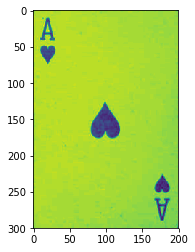

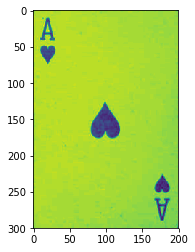

[39473.61173667479, 64208.037290207554, 42662.86508422537, 9472.53002704659, 42242.48515070033, 34016.07682591029, 56877.97129283188, 22521.33317164472, 81397.01810625875, 130265.40369789398, 30077.87748423248]
The rank of the card is: A
[4047.847429259623, 8487.61975396673, 15960.29317589372, 7480.9304851607]
The suit of the card is: Hearts


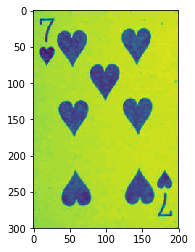

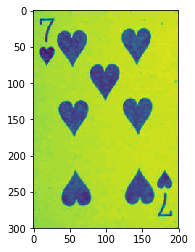

[39554.34525872891, 61274.28246649797, 12663.30562606504, 31910.732926962242, 50108.966713844544, 37364.79495212468, 56869.8468221336, 26751.415075669916, 82533.46292161402, 124197.1213754162, 27120.823204119384]
The rank of the card is: 7
[2899.182500756875, 7321.316105901875, 14297.31393966382, 7147.289472861112]
The suit of the card is: Hearts
[['2', 'Clubs'], ['3', 'Clubs'], ['10', 'Clubs'], ['A', 'Hearts'], ['7', 'Hearts']]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
full house


In [15]:
imarray= np.array(cv2.imread('./im9.jpeg', 0))
cntsarray= card_detect('./im9.jpeg')
print (len(cntsarray))
cards= rankplussuit_detect2(imarray, cntsarray)
#cards should be a list of 7
print (handDetector(cards))